In [1]:
import warnings
import logging
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message=".*NOT subset.*")
logging.getLogger("fontTools.subset").setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import scipy.sparse
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
import matplotlib.font_manager as fm
import gseapy as gp
from pathlib import Path

In [2]:
# Path to font
helvetica_neue_path = Path.home() / ".local/share/fonts/HelveticaNeue-Regular.ttf"

# Create a FontProperties object
prop_neue = fm.FontProperties(fname=helvetica_neue_path)
helvetica_neue_name = prop_neue.get_name()

# Custom font/graphing for Seaborn
custom_context = {
    'font.size': 7,
    'axes.labelsize': 7,
    'axes.titlesize': 7,
    'legend.fontsize': 7,
    'axes.linewidth': 0.6,
    'grid.linewidth': 0.6,
    'lines.linewidth': 0.6,
    'lines.markersize': 3,
    'patch.linewidth': 0.6,
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.title_fontsize': 7,
}

# Additional custom aesthetics for Seaborn
custom_style = {
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.grid': False,
    'grid.color': '#EAEAEA',
    'grid.linestyle': '--',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'ytick.left': True,
    'xtick.bottom': True,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': False,
    'axes.spines.top': False
}

# Use set_theme and pass rc with font settings
sns.set_theme(
    context=custom_context,
    style=custom_style,
    rc={
        'font.family': 'sans-serif',
        'font.sans-serif': [helvetica_neue_name],
        'font.size': 7,
        'axes.labelsize': 7,
        'axes.titlesize': 7,
        'legend.fontsize': 7,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7
    }
)

plt.rcParams['svg.fonttype'] = 'none'

In [3]:
# Set root and output directory
REPO_ROOT = Path.cwd().resolve()
output_dir = REPO_ROOT / "figure6_outputs"
output_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Import anndata object
adata_path = (REPO_ROOT / "GSE290679_10069-MS_allsamples_processed_labeled_filtered.h5ad").resolve()

if not adata_path.exists():
    raise FileNotFoundError(
        f"AnnData file not found at:\n{adata_path}\n\n"
        "Download the file from GEO (GSE290679) and place it in the repository root."
    )

adata = sc.read_h5ad(adata_path)
adata

AnnData object with n_obs × n_vars = 644147 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.ribosomal', 'percent.heme', 'percent.mt', 'percent_mito_filtered', 'percent_feature_filtered', 'percent_doublets', 'SCARAB_ID', 'Batch', 'Age', 'Biologic_Sex', 'ICU', 'Group', 'Source', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'highlight', 'leiden-sub', 'celltype_coarse', 'celltype_fine', 'umap_x', 'umap_y', 'group_density'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Batch_colors', 'Biologic_Sex_colors', 'Group_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltype_coarse_colors', 'celltype_fine_colors', 'group_density_params', 'highlight_colors', 'hvg', 'leiden', 'leiden-sub_colors', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scVI_normalized'
    ob

In [5]:
# Load pseudobulk DESeq2 output for naive
df_sep_path_naive = REPO_ROOT / "CISep-vs-NHC_Naive.csv"

if not df_sep_path_naive.exists():
    raise FileNotFoundError(
        f"Missing required Figure 5 input file:\n{df_sep_path_naive}\n\n"
        "This file is derived from Supplementary Table 1 of the published article.\n"
        "Download from:\n"
        "https://www.nature.com/articles/s41590-025-02390-6\n"
        "and extract the corresponding CSV before running this notebook."
    )

df = pd.read_csv(df_sep_path_naive)

# Prepare the ranked list using gene names and Wald statistics
rnk_file = df[["Unnamed: 0", "stat"]].copy()
rnk_file.columns = ["Gene", "Score"]
rnk_file["Gene"] = rnk_file["Gene"].str.upper()
rnk_file = rnk_file.drop_duplicates().sort_values(by="Score", ascending=False)

# Run preranked GSEA
pre_res = gp.prerank(
    rnk=rnk_file,
    gene_sets="MSigDB_Hallmark_2020",
    min_size=15,
    max_size=500,
    permutation_num=1000,
    outdir=REPO_ROOT / "gsea_results_hallmark_cd4tnaive",
    seed=42,
    verbose=True
)

2026-01-13 10:09:11,576 [INFO] Parsing data files for GSEA.............................
2026-01-13 10:09:11,576 [INFO] Enrichr library gene sets already downloaded in: /home/mstier/.cache/gseapy, use local file
2026-01-13 10:09:11,579 [INFO] 0003 gene_sets have been filtered out when max_size=500 and min_size=15
2026-01-13 10:09:11,580 [INFO] 0047 gene_sets used for further statistical testing.....
2026-01-13 10:09:11,580 [INFO] Start to run GSEA...Might take a while..................
2026-01-13 10:09:18,265 [INFO] Start to generate gseapy reports, and produce figures...
2026-01-13 10:09:18,266 [INFO] Congratulations. GSEApy runs successfully................



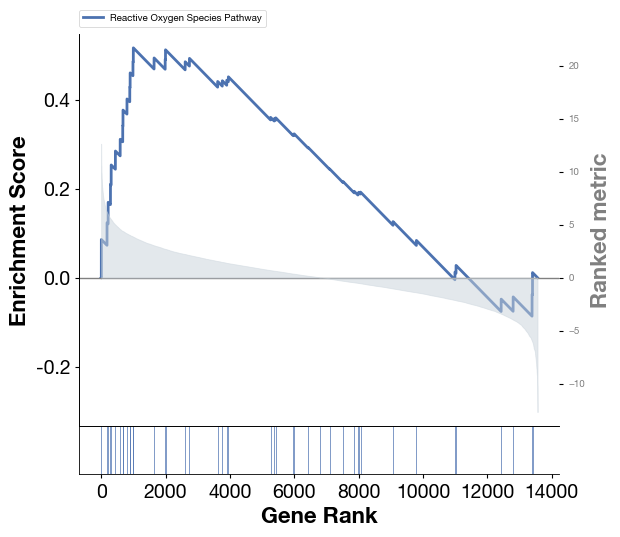

Pathway: Reactive Oxygen Species Pathway
  NES: 1.8802093871013517
  FDR q-value: 0.0003656074647506716



In [6]:
# Pathways for running score plot
pathways_to_plot = [
    "Reactive Oxygen Species Pathway"
]

available_pathways = [p for p in pathways_to_plot if p in pre_res.res2d["Term"].values]

# Plot
if available_pathways:
    axs = pre_res.plot(
        terms=available_pathways
    )
    
    plt.savefig(output_dir / "GSEA_running_ROS_CD4TNaive.svg")
    plt.show()

    filtered_results = pre_res.res2d[pre_res.res2d["Term"].isin(available_pathways)]
    for _, row in filtered_results.iterrows():
        term = row["Term"]
        nes = row.get("NES", "N/A")
        q_value = row.get("FDR q-val", row.get("Adjusted P-value", "N/A"))
        print(f"Pathway: {term}\n  NES: {nes}\n  FDR q-value: {q_value}\n")

In [7]:
# Load pseudobulk DESeq2 output for EffEM
df_sep_path_effem = REPO_ROOT / "CISep-vs-NHC_EffEM.csv"

if not df_sep_path_effem.exists():
    raise FileNotFoundError(
        f"Missing required Figure 5 input file:\n{df_sep_path_effem}\n\n"
        "This file is derived from Supplementary Table 1 of the published article.\n"
        "Download from:\n"
        "https://www.nature.com/articles/s41590-025-02390-6\n"
        "and extract the corresponding CSV before running this notebook."
    )

df = pd.read_csv(df_sep_path_effem)

# Prepare the ranked list using gene names and Wald statistics
rnk_file = df[["Unnamed: 0", "stat"]].copy()
rnk_file.columns = ["Gene", "Score"]
rnk_file["Gene"] = rnk_file["Gene"].str.upper()
rnk_file = rnk_file.drop_duplicates().sort_values(by="Score", ascending=False)

# Run preranked GSEA
pre_res = gp.prerank(
    rnk=rnk_file,
    gene_sets="MSigDB_Hallmark_2020",
    min_size=15,
    max_size=500,
    permutation_num=1000,
    outdir=REPO_ROOT / "gsea_results_hallmark_cd4teffem",
    seed=42,
    verbose=True
)

2026-01-13 10:09:18,524 [INFO] Parsing data files for GSEA.............................
2026-01-13 10:09:18,525 [INFO] Enrichr library gene sets already downloaded in: /home/mstier/.cache/gseapy, use local file
2026-01-13 10:09:18,528 [INFO] 0002 gene_sets have been filtered out when max_size=500 and min_size=15
2026-01-13 10:09:18,528 [INFO] 0048 gene_sets used for further statistical testing.....
2026-01-13 10:09:18,529 [INFO] Start to run GSEA...Might take a while..................
2026-01-13 10:09:25,479 [INFO] Start to generate gseapy reports, and produce figures...
2026-01-13 10:09:25,480 [INFO] Congratulations. GSEApy runs successfully................



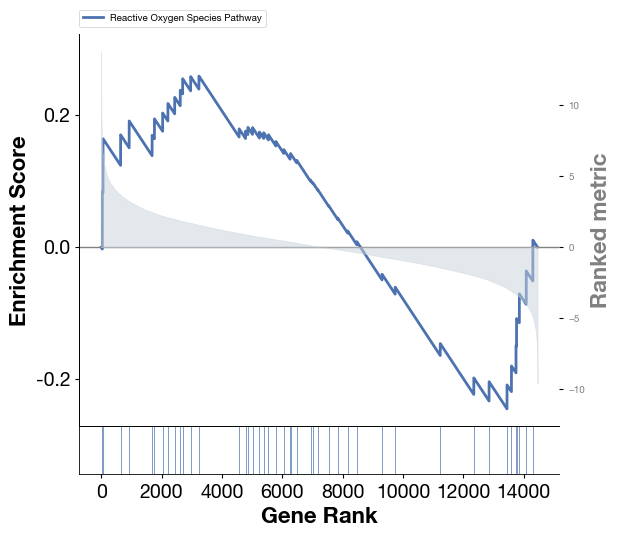

Pathway: Reactive Oxygen Species Pathway
  NES: 0.9397304986868229
  FDR q-value: 0.6418795715325684



In [8]:
# Pathways for running score plot
pathways_to_plot = [
    "Reactive Oxygen Species Pathway"
]

available_pathways = [p for p in pathways_to_plot if p in pre_res.res2d["Term"].values]

# Plot
if available_pathways:
    axs = pre_res.plot(
        terms=available_pathways
    )
    
    plt.savefig(output_dir / "GSEA_running_ROS_CD4TEffEM.svg")
    plt.show()

    filtered_results = pre_res.res2d[pre_res.res2d["Term"].isin(available_pathways)]
    for _, row in filtered_results.iterrows():
        term = row["Term"]
        nes = row.get("NES", "N/A")
        q_value = row.get("FDR q-val", row.get("Adjusted P-value", "N/A"))
        print(f"Pathway: {term}\n  NES: {nes}\n  FDR q-value: {q_value}\n")

In [9]:
# Load pseudobulk DESeq2 output for Treg
df_sep_path_treg = REPO_ROOT / "CISep-vs-NHC_Treg.csv"

if not df_sep_path_treg.exists():
    raise FileNotFoundError(
        f"Missing required Figure 5 input file:\n{df_sep_path_treg}\n\n"
        "This file is derived from Supplementary Table 1 of the published article.\n"
        "Download from:\n"
        "https://www.nature.com/articles/s41590-025-02390-6\n"
        "and extract the corresponding CSV before running this notebook."
    )

df = pd.read_csv(df_sep_path_treg)

# Prepare the ranked list using gene names and Wald statistics
rnk_file = df[["Unnamed: 0", "stat"]].copy()
rnk_file.columns = ["Gene", "Score"]
rnk_file["Gene"] = rnk_file["Gene"].str.upper()
rnk_file = rnk_file.drop_duplicates().sort_values(by="Score", ascending=False)

# Run preranked GSEA
pre_res = gp.prerank(
    rnk=rnk_file,
    gene_sets="MSigDB_Hallmark_2020",
    min_size=15,
    max_size=500,
    permutation_num=1000,
    outdir=REPO_ROOT / "gsea_results_hallmark_cd4treg",
    seed=42,
    verbose=True
)

2026-01-13 10:09:25,724 [INFO] Parsing data files for GSEA.............................
2026-01-13 10:09:25,724 [INFO] Enrichr library gene sets already downloaded in: /home/mstier/.cache/gseapy, use local file
2026-01-13 10:09:25,727 [INFO] 0003 gene_sets have been filtered out when max_size=500 and min_size=15
2026-01-13 10:09:25,729 [INFO] 0047 gene_sets used for further statistical testing.....
2026-01-13 10:09:25,729 [INFO] Start to run GSEA...Might take a while..................
2026-01-13 10:09:31,816 [INFO] Start to generate gseapy reports, and produce figures...
2026-01-13 10:09:31,817 [INFO] Congratulations. GSEApy runs successfully................



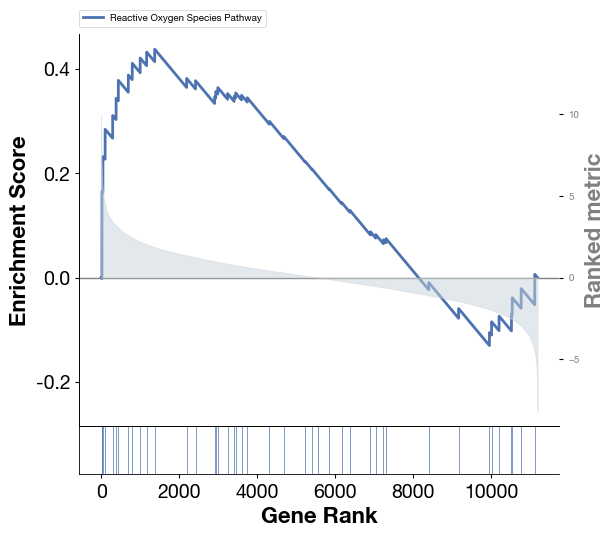

Pathway: Reactive Oxygen Species Pathway
  NES: 1.619609096998752
  FDR q-value: 0.008845474967907574



In [10]:
# Pathways for running score plot
pathways_to_plot = [
    "Reactive Oxygen Species Pathway"
]

available_pathways = [p for p in pathways_to_plot if p in pre_res.res2d["Term"].values]

# Plot
if available_pathways:
    axs = pre_res.plot(
        terms=available_pathways
    )
    
    plt.savefig(output_dir / "GSEA_running_ROS_CD4Treg.svg")
    plt.show()

    filtered_results = pre_res.res2d[pre_res.res2d["Term"].isin(available_pathways)]
    for _, row in filtered_results.iterrows():
        term = row["Term"]
        nes = row.get("NES", "N/A")
        q_value = row.get("FDR q-val", row.get("Adjusted P-value", "N/A"))
        print(f"Pathway: {term}\n  NES: {nes}\n  FDR q-value: {q_value}\n")

In [11]:
# Subset to CD4 T cell types of interest
subset_celltypes = ["CD4 T Naive", "CD4 T Eff/EM", "CD4 Treg"]

adata_subset = adata[adata.obs["celltype_fine"].isin(subset_celltypes)].copy()

adata_subset.var_names = adata_subset.var_names.str.upper()

# Create combined group label and set plotting order
adata_subset.obs["Group_CellType"] = (
    adata_subset.obs["Group"].astype(str) + " " + adata_subset.obs["celltype_fine"].astype(str)
)

order = [
    "NHC CD4 T Naive",
    "CI-Sep CD4 T Naive",
    "NHC CD4 T Eff/EM",
    "CI-Sep CD4 T Eff/EM",
    "NHC CD4 Treg",
    "CI-Sep CD4 Treg",
]

adata_subset.obs["Group_CellType"] = adata_subset.obs["Group_CellType"].astype(
    pd.CategoricalDtype(categories=order, ordered=True)
)

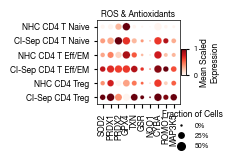

In [12]:
# Define plotting order
celltype_order = [
    'NHC CD4 T Naive', 'CI-Sep CD4 T Naive',
    'NHC CD4 T Eff/EM', 'CI-Sep CD4 T Eff/EM',
    'NHC CD4 Treg', 'CI-Sep CD4 Treg'
]

# ROS & Antioxidants gene list
ros_genes = ["SOD2", "PRDX1", "PRDX2", "GPX4", "TXN", "GSR", "NQO1", "CYBA", "ROMO1", "MAP3K5"]

subpanel_genes = {"ROS & Antioxidants": ros_genes}

# Prepare gene expression data (mean + %expressing)
adata_exp = adata_subset.raw.to_adata()
adata_sub = adata_exp[:, ros_genes]
X = adata_sub.X
if scipy.sparse.issparse(X):
    X = X.tocsr()

cell_types = adata_sub.obs['Group_CellType'].values
plot_data = []
for ct in celltype_order:
    idx = np.where(cell_types == ct)[0]
    if len(idx) == 0:
        continue
    X_ct = X[idx]
    mean = np.asarray(X_ct.mean(axis=0)).ravel() if scipy.sparse.issparse(X_ct) else X_ct.mean(axis=0)
    pct  = np.asarray((X_ct > 0).mean(axis=0)).ravel()*100 if scipy.sparse.issparse(X_ct) else (X_ct > 0).mean(axis=0)*100
    for gene_idx, gene in enumerate(ros_genes):
        plot_data.append((ct, gene, mean[gene_idx], pct[gene_idx]))

# Create dataframe for plotting
plot_df = pd.DataFrame(plot_data, columns=["celltype", "genes", "mean_expression", "percent_cells"])
plot_df["celltype"] = pd.Categorical(plot_df["celltype"], categories=celltype_order, ordered=True)
plot_df["genes"] = pd.Categorical(plot_df["genes"], categories=ros_genes, ordered=True)
plot_df["percent_cells_clipped"] = np.clip(plot_df["percent_cells"], 0, 50)
plot_df["mean_expression_scaled"] = (
    plot_df.groupby("genes")["mean_expression"]
    .transform(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-6))
)

# Create dotplot
panel_widths = [len(ros_genes)]
total_width = 1.15
height = 1.1

fig, axes = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(total_width, height),
    gridspec_kw={"width_ratios": panel_widths},
    sharey=True
)

axes = [axes]

for i, (ax, (panel_name, genes_subset)) in enumerate(zip(axes, subpanel_genes.items())):
    sub_df = plot_df[plot_df["genes"].isin(genes_subset)].copy()
    sub_df["genes"] = pd.Categorical(sub_df["genes"], categories=genes_subset, ordered=True)
    sub_df["celltype"] = pd.Categorical(sub_df["celltype"], categories=celltype_order, ordered=True)

    sns.scatterplot(
        data=sub_df, x="genes", y="celltype",
        size="percent_cells_clipped",
        size_norm=(0, 50),
        hue="mean_expression_scaled",
        palette="Reds",
        sizes=(0.5, 30),
        legend=False,
        ax=ax
    )

    ax.set_xticks(np.arange(len(genes_subset)))
    ax.set_xticklabels(genes_subset, fontsize=6, rotation=90)
    ax.set_xlim(-0.75, len(genes_subset) - 0.25)
    ax.set_ylim(-0.5, len(celltype_order) - 0.5)
    ax.invert_yaxis()
    ax.set_xlabel('')
    ax.set_title(panel_name, fontsize=6, pad=2)
    ax.set_ylabel('')

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.5)

axes[0].set_yticks(np.arange(len(celltype_order)))
axes[0].set_yticklabels(celltype_order, fontsize=6)
axes[0].tick_params(axis='y', length=2)

plt.subplots_adjust(wspace=0.05)

norm = mcolors.Normalize(vmin=0, vmax=1)
sm = ScalarMappable(norm=norm, cmap='Reds')
sm.set_array([])

cbar = fig.colorbar(
    sm, ax=axes, orientation='vertical',
    fraction=0.05, pad=0.02, aspect=6
)
cbar.set_label("Mean Scaled\nExpression", fontsize=6, labelpad=2)
cbar.ax.tick_params(labelsize=5, length=2)

size_min, size_max = 0.5, 30
percent_values = [0, 25, 50]
size_values = [size_min + (p/50)*(size_max-size_min) for p in percent_values]

dot_handles = [
    Line2D([], [], marker='o', color='black', linestyle='None',
           markersize=np.sqrt(s), label=f"{p}%", alpha=1)
    for p, s in zip(percent_values, size_values)
]

fig.legend(
    handles=dot_handles, title="Fraction of Cells",
    loc='lower right', fontsize=5, title_fontsize=6,
    frameon=False, handletextpad=1, labelspacing=0.6, borderpad=0.5
)

plt.savefig(output_dir / "CD4_ROS_dotplot.svg")
plt.show()